# Descriptive Analysis on SATP Data

In [283]:
# Import data analysis and NLP packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
plt.rcParams["figure.figsize"] = [9, 7]
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import gensim
import multiprocessing
import plotly.graph_objects as go
import plotly.express as px

#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
#!pip install --upgrade pip
#!pip install --upgrade Pillow
#!pip install --upgrade gensim

#Filepaths
home = "../"
data = home + "data/"

In this notebook, I generate descriptive statistics on the SATP dataset to identify topics and themes that can inform further machine learning.

## Preprocessing

In [211]:
# Original dataset
satp = pd.read_csv(data + 'dataset_satp_2019.csv')
satp.head()

,description,year
0,"A Special Police Officer (SPO), identified as ...",2019.0
1,Armed Forces Special Powers Act (AFSPA) has be...,2019.0
2,"On January 1, an ex-United Liberation Front of...",2019.0
3,The number of objections filed on the draft of...,2019.0
4,The Year 2019 will be challenging for the Odis...,2019.0


In [212]:
# Define function for string cleaning + lemmatizing
def nlp_pipeline(data):
    # Convert to lower case
    data['description'] = data['description'].str.lower()
    # Remove duplicate values
    data = data.drop_duplicates().reset_index(drop=True)
    row_lst = []
    lem = WordNetLemmatizer()
    stop = stopwords.words('english')
    for i in range(len(data)):
        row = str(data['description'].iloc[i])
        # Remove non-alphanumeric characters
        row = re.sub(r'[^0-9A-Za-z]',  ' ', row)
        # Remove stopwords and lemmatizing
        row = ' '.join([lem.lemmatize(word) for word in row.split() if not word in set(stopwords.words('english'))])
        row_lst.append(row)
    data['description'] = row_lst
    return data

# Function for removing additional words
def remove_words(data, words_to_remove):
    row_lst = []
    for i in range(len(data)):
        row = str(data['description'].iloc[i])
        for word in words_to_remove:
            row = re.sub(word, '', row)
        row_lst.append(row)
    data['description'] = row_lst
    return data

In [213]:
# Create the cleaned SATP dataset
cleaned_satp = nlp_pipeline(satp)

In [255]:
# Additional words to remove
words_to_remove = ['said', 'report', 'district', 'india', 'indian', 'police', 'area', 'people', 'time', 'daily']

# Create the cleaned SATP dataset
cleaned_satp = remove_words(cleaned_satp, words_to_remove)
cleaned_satp.head()

,description,year,length
0,special officer spo identified sameer ahmad k...,2019.0,338
1,armed force special power act afspa extended s...,2019.0,457
2,january 1 ex united liberation front asom ulfa...,2019.0,383
3,number objection filed draft national register...,2019.0,422
4,year 2019 challenging odisha many important e...,2019.0,305


In [215]:
# Add a lengths column
length = cleaned_satp['description'].apply(len)
cleaned_satp['length'] = length
cleaned_satp.head()

,description,year,length
0,special officer spo identified sameer ahmad k...,2019.0,338
1,armed force special power act afspa extended s...,2019.0,457
2,january 1 ex united liberation front asom ulfa...,2019.0,383
3,number objection filed draft national register...,2019.0,422
4,year 2019 challenging odisha many important e...,2019.0,305


## Descriptive Analysis

### 1. Distribution of Length

<Figure size 864x864 with 0 Axes>

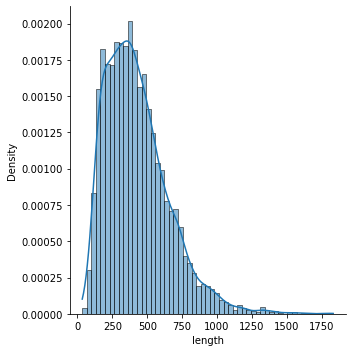

In [264]:
sns.displot(cleaned_satp['length'], kde=True, stat='density')
plt.show()

### 2. Wordcloud

Here I generate a wordcloud to identify which words occur the most often.

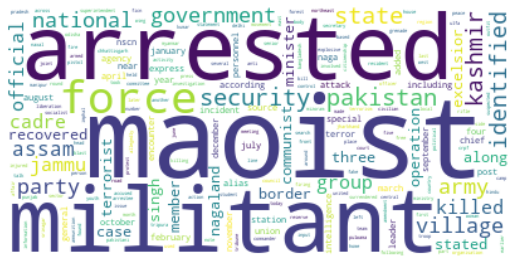

In [281]:
def wordcloud(data):
    text = ''
    # Process text
    for i in range(len(data)):
        text = text + ' ' + data['description'][i]
    # Plot the wordcloud
    word_cloud = WordCloud(collocations=False, background_color='white', min_word_length=4).generate(text)
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    return word_cloud.words_

word_cloud = wordcloud(cleaned_satp)

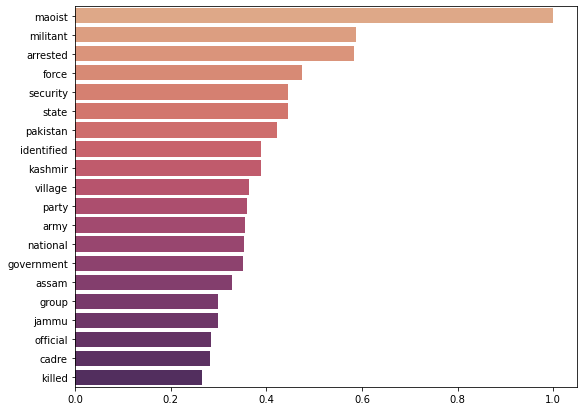

In [284]:
def freq_plot(rel_freq, n):
    sns.barplot(y=list(rel_freq.keys())[:n], x=list(rel_freq.values())[:n], palette='flare')
    plt.show()

freq_plot(word_cloud, 20)

In [377]:
for i in range(20):
    key = list(rel_freq.keys())[i]
    print(key + ': ' + str(rel_freq[key]))

maoist: 1.0
militant: 0.5880597014925373
arrested: 0.5832835820895522
force: 0.47432835820895525
security: 0.44597014925373135
state: 0.4444776119402985
pakistan: 0.4223880597014925
identified: 0.38925373134328356
kashmir: 0.388955223880597
village: 0.3635820895522388
party: 0.35880597014925375
army: 0.35522388059701493
national: 0.35313432835820896
government: 0.35074626865671643
assam: 0.32865671641791044
group: 0.29940298507462687
jammu: 0.2991044776119403
official: 0.2847761194029851
cadre: 0.282089552238806
daily: 0.2817910447761194


### 3. N-Grams

Here I generate and plot 2-gram, 3-gram and 4-gram to identify which words occur together the most often.

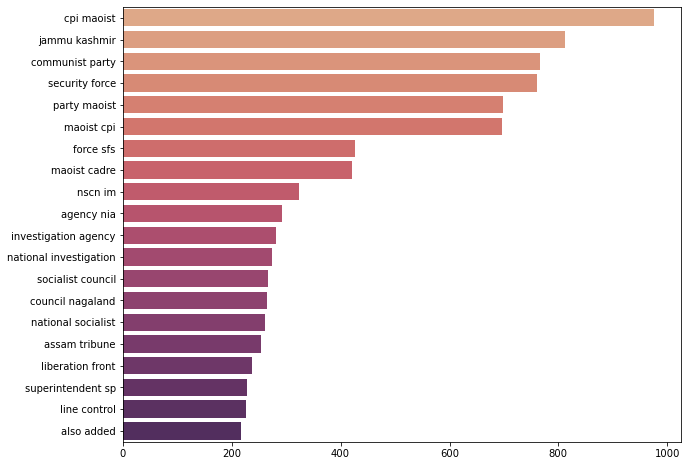

In [258]:
# Process data
ngram_text = list(cleaned_satp['description'])

# Define function for generating and plotting the ngrams
def generate_ngrams(text, n, top_n):
    vec = CountVectorizer(ngram_range=(n, n)).fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    sns.barplot(y=[i[0] for i in words_freq][:top_n], x=[i[1] for i in words_freq][:top_n], palette='flare')
    plt.show()
    return words_freq

# Bigram
ngram_2 = generate_ngrams(ngram_text, 2, 20)

In [259]:
ngram_2[:20]

[('cpi maoist', 976),
 ('jammu kashmir', 812),
 ('communist party', 767),
 ('security force', 760),
 ('party maoist', 698),
 ('maoist cpi', 697),
 ('force sfs', 426),
 ('maoist cadre', 420),
 ('nscn im', 323),
 ('agency nia', 292),
 ('investigation agency', 281),
 ('national investigation', 274),
 ('socialist council', 267),
 ('council nagaland', 264),
 ('national socialist', 261),
 ('assam tribune', 253),
 ('liberation front', 237),
 ('superintendent sp', 228),
 ('line control', 226),
 ('also added', 217)]

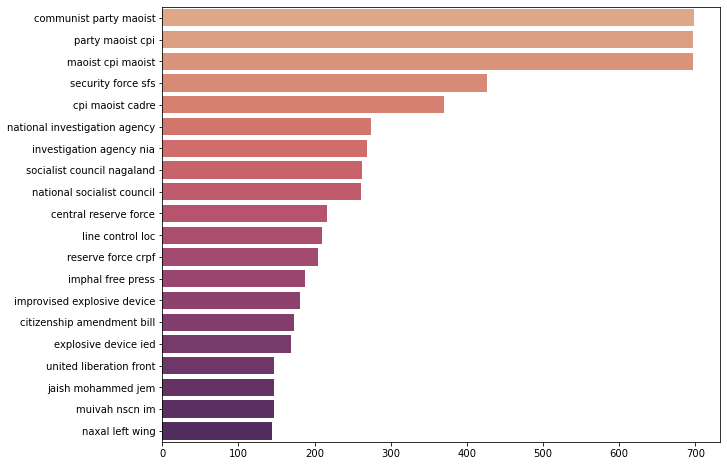

In [260]:
# Trigram
ngram_3 = generate_ngrams(ngram_text, 3, 20)

In [261]:
ngram_3[:20]

[('communist party maoist', 698),
 ('party maoist cpi', 697),
 ('maoist cpi maoist', 697),
 ('security force sfs', 426),
 ('cpi maoist cadre', 370),
 ('national investigation agency', 274),
 ('investigation agency nia', 269),
 ('socialist council nagaland', 262),
 ('national socialist council', 261),
 ('central reserve force', 216),
 ('line control loc', 210),
 ('reserve force crpf', 205),
 ('imphal free press', 188),
 ('improvised explosive device', 181),
 ('citizenship amendment bill', 173),
 ('explosive device ied', 169),
 ('united liberation front', 147),
 ('jaish mohammed jem', 147),
 ('muivah nscn im', 147),
 ('naxal left wing', 144)]

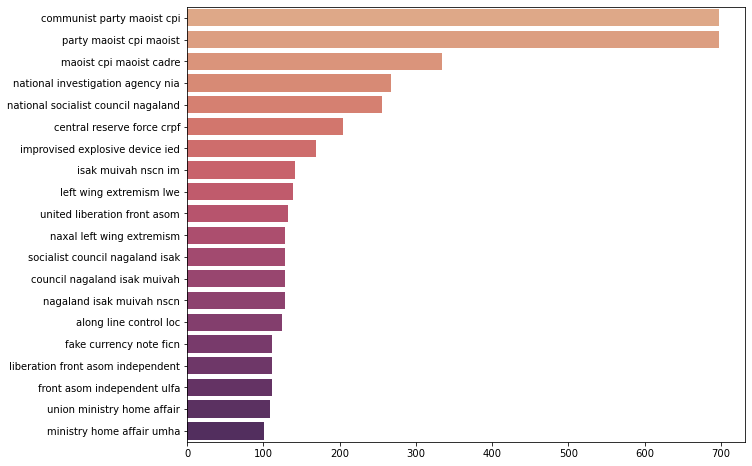

In [262]:
# 4-gram
ngrams_4 = generate_ngrams(ngram_text, 4, 20)

In [225]:
ngrams_4[:20]

[('communist party maoist cpi', 697),
 ('party maoist cpi maoist', 697),
 ('maoist cpi maoist cadre', 335),
 ('national investigation agency nia', 268),
 ('national socialist council nagaland', 256),
 ('central reserve force crpf', 204),
 ('improvised explosive device ied', 169),
 ('isak muivah nscn im', 142),
 ('left wing extremism lwe', 139),
 ('united liberation front asom', 132),
 ('naxal left wing extremism', 128),
 ('socialist council nagaland isak', 128),
 ('council nagaland isak muivah', 128),
 ('nagaland isak muivah nscn', 128),
 ('along line control loc', 125),
 ('fake currency note ficn', 112),
 ('liberation front asom independent', 111),
 ('front asom independent ulfa', 111),
 ('union ministry home affair', 109),
 ('ministry home affair umha', 101)]

### 4. Word Embeddings

Here I visualize words in a vector space to identify clusters of words that have similar meaning. Code is adapted from [this article](https://habr.com/en/companies/vk/articles/449984/).

Other resources:
- [TSNE function documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

**Define Functions**

In [226]:
# Define a function for generating embeddings
def generate_embeddings(train, sample, n_cluster):
    ''' 
    Parameters:
        train: trainig data (as a list of split words)
        sample: sample of words to generate embeddings for
        n_cluster: number of words in each cluster
    
    Output:
        word_clusters: list of clusters of words the model generated
        embedding_clusters: distances between words in each cluster
    '''
    # Initialize the model
    w2v_model = gensim.models.Word2Vec(train, workers=multiprocessing.cpu_count())
    
    # Generate clusters of similar words and their simliarities for the given sample of words
    embedding_clusters = []
    word_clusters = []
    for word in sample:
        try:
            embeddings = []
            words = []
            for similar_word, _ in w2v_model.wv.most_similar(word, topn=n_cluster):
                words.append(similar_word)
                embeddings.append(w2v_model.wv[similar_word])
            embedding_clusters.append(embeddings)
            word_clusters.append(words)
        except:
            pass
        
    return word_clusters, embedding_clusters

In [227]:
# Define function for dimensionality reduction using TSNE
def tsne(embedding_clusters, perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32):
    '''
    Parameters:
        embedding_clusters: word embeddings
        See documentation for TSNE function for the other parameters
        
    Output:
        embeddings_new: word embeddings with reduced dimensionality
    '''
    # Initialize the TSNE model
    tsne_model_en_2d = TSNE(perplexity=perplexity, n_components=n_components, init=init, n_iter=n_iter, random_state=random_state)
    
    # Find dimensions
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    
    # Reduce dimensions using the TSNE model
    embeddings_new = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, n_components)
    
    return embeddings_new

In [228]:
# Plotting the clusters
def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    '''
    Parameters:
        labels: sample of words used for generating the embeddings
    '''
    plt.figure(figsize=(12, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, color=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(bbox_to_anchor=(1.2, 1))
    plt.grid(True)
    plt.show()

**Word Embeddings for a Random Sample**

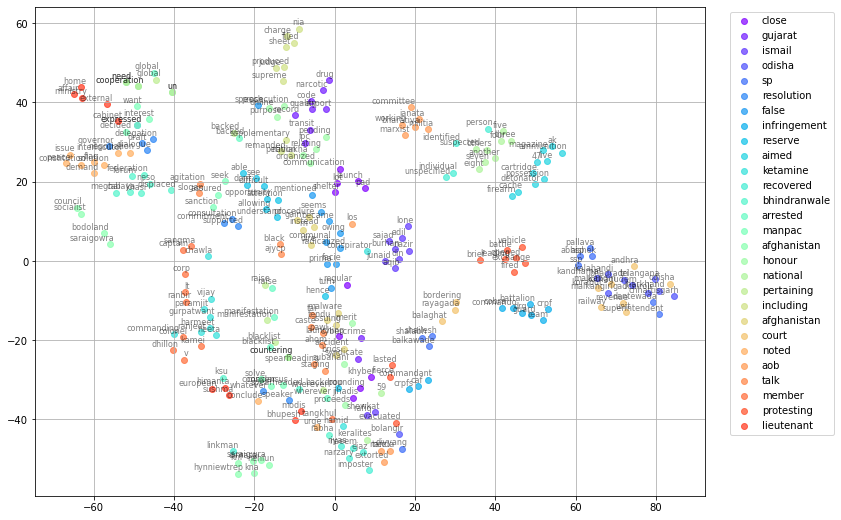

In [229]:
# Prepare the data
rand_train = [text.split() for text in cleaned_satp['description']]

# Generate a random sample of 30 words 
rand_sample = np.random.choice(np.array(text.split()), 30)

# Generate embeddings
rand_clusters, rand_embeddings = generate_embeddings(rand_train, rand_sample, 10)

# Reduce dimensions
rand_new_embeddings = tsne(rand_embeddings)

# Plot the clusters
tsne_plot_similar_words(rand_sample, rand_new_embeddings, rand_clusters, a=0.7)

In [305]:
rand_clusters

[['lot',
  'pounding',
  'pad',
  'launch',
  'regular',
  'launching',
  'communication',
  'jihadis',
  'khyber',
  'shelter'],
 ['quality',
  'syndicate',
  'cybercrime',
  'narcotic',
  'drug',
  'code',
  'transit',
  'airport',
  'record',
  'ipc'],
 ['din',
  'lone',
  'adil',
  'rafiq',
  'burhan',
  'aqib',
  'junaid',
  'nazir',
  'sajad',
  'showkat'],
 ['jharkhand',
  'malkangiri',
  'chhattisgarh',
  'kandhamal',
  'telangana',
  'bolangir',
  'kothagudem',
  'bhadradri',
  'kalahandi',
  'gadchiroli'],
 ['asp',
  'superintendent',
  'abhishek',
  'pallava',
  'balkawade',
  'ssp',
  'shalabh',
  'divyang',
  'dantewada',
  'shailesh'],
 ['dialogue',
  'consultation',
  'expressed',
  'commitment',
  'governor',
  'whatever',
  'speaker',
  'draft',
  'supported',
  'delegation'],
 ['speech',
  'mentioned',
  'owing',
  'facie',
  'prima',
  'seems',
  'turn',
  'became',
  'communal',
  'radicalized'],
 ['crpf',
  'drg',
  'guard',
  'caf',
  'battalion',
  'cobra',
  'co

---

## Word Embeddings for Complete SATP Data

In [231]:
# Load complete SATP data
filepath = '/Users/vaidehibulusu/Downloads/'
satp_full = pd.read_csv(filepath + 'dataset_satp_complete.csv')
satp_full.head()

,description,year
0,A lower rung Communist Party of India-Maoist (...,2023.0
1,An old mortar shell was found 150 metres away ...,2023.0
2,Communist Party of India-Maoist (CPI-Maoist) c...,2023.0
3,"On January 1, a civilian, identified as Sameer...",2023.0
4,"On January 1, a Pakistani drone was spotted by...",2023.0


In [232]:
satp_full.shape

(130790, 2)

In [234]:
# Clean data
# This takes a while to run
cleaned_satp_full = nlp_pipeline(satp_full)

In [235]:
cleaned_satp_full = remove_words(cleaned_satp_full, words_to_remove) 
cleaned_satp_full.head()

,description,year
0,lower rung communist party maoist cpi maoist ...,2023.0
1,old mortar shell found 150 metre away railway ...,2023.0
2,communist party maoist cpi maoist cadre edly ...,2023.0
3,january 1 civilian identified sameer ahmed mal...,2023.0
4,january 1 pakistani drone spotted border secur...,2023.0


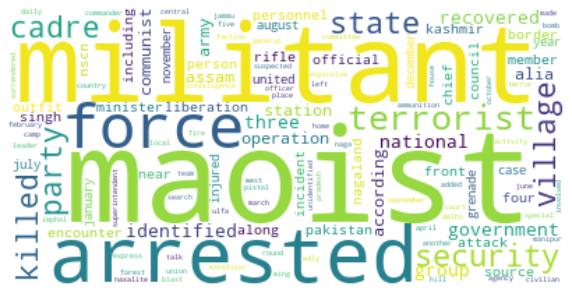

In [266]:
# Generate wordcloud
wordcloud_satp_full = wordcloud(cleaned_satp_full)

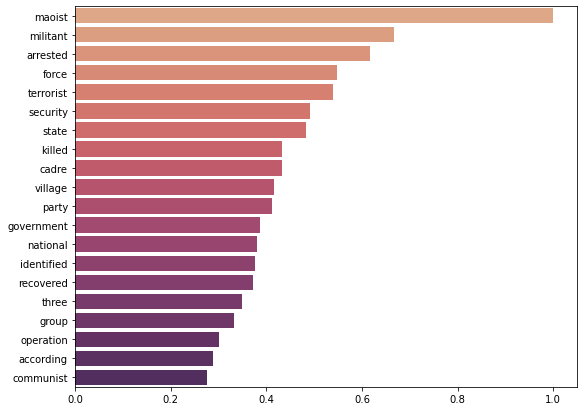

In [285]:
# Frequency plot of top 20 most frequent words
freq_plot(wordcloud_satp_full, 20)

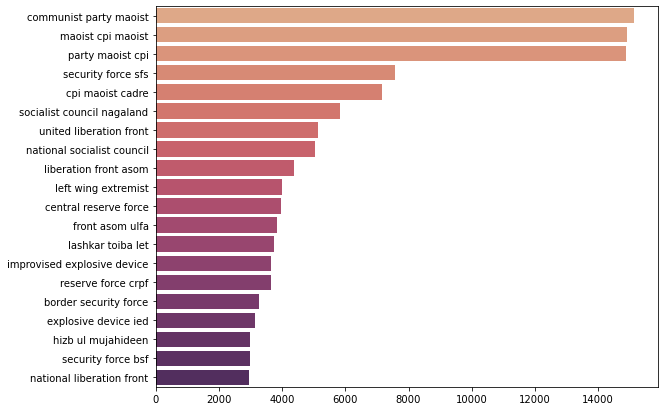

In [378]:
# Top 20 3-gram
ngram_3_satp_full = generate_ngrams(list(cleaned_satp_full['description']), 3, 20)

In [379]:
# Prepare the data
full_train = [text.split() for text in cleaned_satp_full['description']]

# Generate a random sample of 20 words
full_sample = np.array(['caste', 'community', 'bomb', 'maoist', 'naxalite', 'politic', 'protest', 'riot', 'nscn', 'socialist', 'communist', 'ficn', 'kashmir', 'jammu', 'militant', 'extremist', 'ulfa', 'terrorist', 'left', 'ndfb'])

# Generate embeddings with 15 words in each cluster
full_clusters, full_embeddings = generate_embeddings(full_train, full_sample, 15)

# Reduce dimensions (10 nearest neighbors, 3 dimensions)
full_new_embeddings = tsne(full_embeddings, perplexity=10, n_components=3)

In [380]:
# Define function for generating 3D plot to visualize the embeddings
def generate_3d_plot(embeddings):
    fig = go.Figure(data=[go.Scatter3d(
        x=embeddings[:, :, 0].flatten(),
        y=embeddings[:, :, 1].flatten(),
        z=embeddings[:, :, 2].flatten(),
        mode='markers',
        marker=dict(size=8, opacity=0.4))])
    fig.update_layout(autosize=False, width=800, height=800)    
    fig.show()
    
generate_3d_plot(full_new_embeddings)

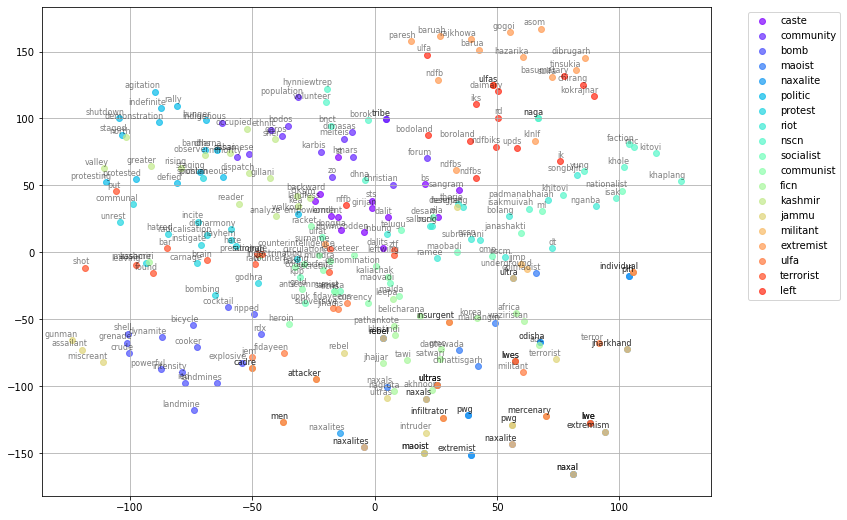

In [381]:
# x-y projection
tsne_plot_similar_words(full_sample, full_new_embeddings[:, :, [0, 1]], full_clusters, a=0.7)

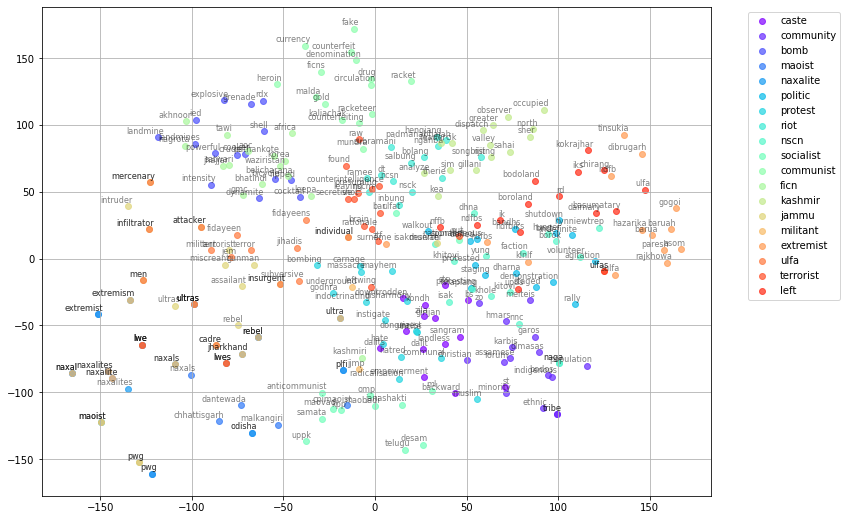

In [382]:
# y-z projection
tsne_plot_similar_words(full_sample, full_new_embeddings[:, :, [1, 2]], full_clusters, a=0.7)

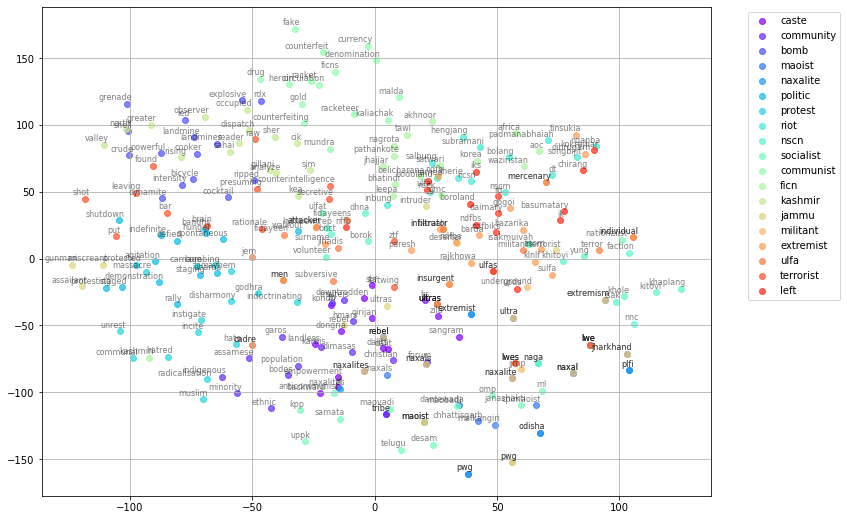

In [383]:
# x-z projection
tsne_plot_similar_words(full_sample, full_new_embeddings[:, :, [0, 2]], full_clusters, a=0.7)

In [384]:
full_clusters

[['dalits',
  'dalit',
  'backward',
  'sts',
  'kondh',
  'landless',
  'empowerment',
  'girijan',
  'dongria',
  'st',
  'tribe',
  'zila',
  'downtrodden',
  'bs',
  'sangram'],
 ['tribe',
  'indigenous',
  'minority',
  'hmars',
  'bodos',
  'dimasas',
  'karbis',
  'ethnic',
  'christian',
  'forum',
  'garos',
  'meiteis',
  'population',
  'assamese',
  'zo'],
 ['ied',
  'landmines',
  'powerful',
  'landmine',
  'cooker',
  'grenade',
  'explosive',
  'intensity',
  'dynamite',
  'rdx',
  'ripped',
  'cocktail',
  'bicycle',
  'crude',
  'shell'],
 ['naxalites',
  'naxalite',
  'pwg',
  'naxal',
  'naxals',
  'cpimaoist',
  'chhattisgarh',
  'ultras',
  'plfi',
  'odisha',
  'rebel',
  'lwe',
  'dantewada',
  'extremist',
  'malkangiri'],
 ['naxal',
  'lwe',
  'maoist',
  'naxalites',
  'extremist',
  'pwg',
  'naxals',
  'rebel',
  'extremism',
  'lwes',
  'ultras',
  'ultra',
  'jharkhand',
  'plfi',
  'odisha'],
 ['demonstration',
  'protesting',
  'staged',
  'dharna',
  '

---